# 고양이, 개 분류 - CNN v2
- Dropout 추가

In [1]:
import cv2
import matplotlib.pyplot as plt


In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-18 02:32:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   156MB/s    in 0.4s    

2022-01-18 02:32:36 (156 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

* 데이터 탐색

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])


['cat.976.jpg', 'cat.230.jpg', 'cat.493.jpg', 'cat.626.jpg', 'cat.186.jpg']
['dog.362.jpg', 'dog.98.jpg', 'dog.667.jpg', 'dog.766.jpg', 'dog.332.jpg']


In [6]:
# 파일 갯수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

* 모델 구성

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)        0

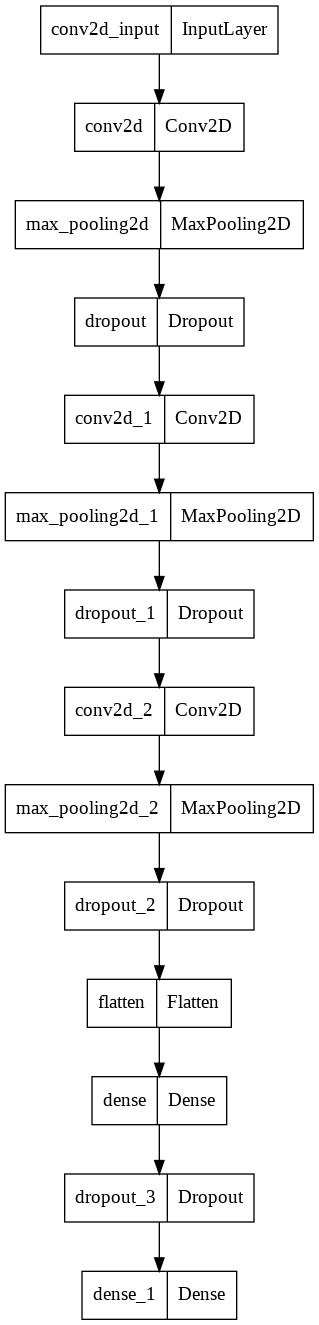

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model)

* 모델 설정

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
train_dir

'cats_and_dogs_filtered/train'

* callback 정의

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [15]:
hist = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=100, 
    steps_per_epoch=100,           # 한 번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=50,            # 한 번의 epoch가 끝났을 때, 테스트에 사용되는 batch에 갯수
    verbose=2, 
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.69304, saving model to best-cat-dog-v2.h5
100/100 - 24s - loss: 0.7918 - accuracy: 0.5120 - val_loss: 0.6930 - val_accuracy: 0.5000 - 24s/epoch - 237ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.69304 to 0.64230, saving model to best-cat-dog-v2.h5
100/100 - 10s - loss: 0.7120 - accuracy: 0.5815 - val_loss: 0.6423 - val_accuracy: 0.6350 - 10s/epoch - 104ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.64230 to 0.61759, saving model to best-cat-dog-v2.h5
100/100 - 10s - loss: 0.6206 - accuracy: 0.6600 - val_loss: 0.6176 - val_accuracy: 0.6540 - 10s/epoch - 104ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.61759 to 0.60010, saving model to best-cat-dog-v2.h5
100/100 - 10s - loss: 0.5817 - accuracy: 0.6970 - val_loss: 0.6001 - val_accuracy: 0.6850 - 10s/epoch - 104ms/step
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.60010
100/100 - 10s - loss: 0.5490 - accuracy: 0.7245 - val_loss: 0.60

In [16]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [17]:
from google.colab import files

up = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.jpg to cat3.jpg
Saving cat4.jpg to cat4.jpg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg
Saving dog4.jpg to dog4.jpg


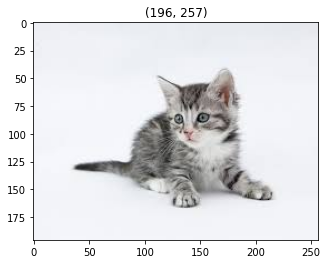

In [19]:
img = cv2.imread('cat1.jpg')[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

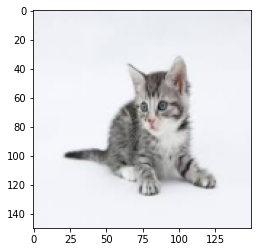

In [20]:
# 150 x 150 size
img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [21]:
best_model.predict(img.reshape(1,150,150,3))

array([[0.]], dtype=float32)

In [22]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300: # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0 cat1.jpg is a cat
0.0 cat2.jpg is a cat
0.0 cat3.jpg is a cat
0.0 cat4.jpg is a cat
1.0 dog1.jpg is a dog
1.0 dog2.jpg is a dog
1.0 dog3.jpg is a dog
1.0 dog4.jpg is a dog


* 학습과정 시각화

In [23]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

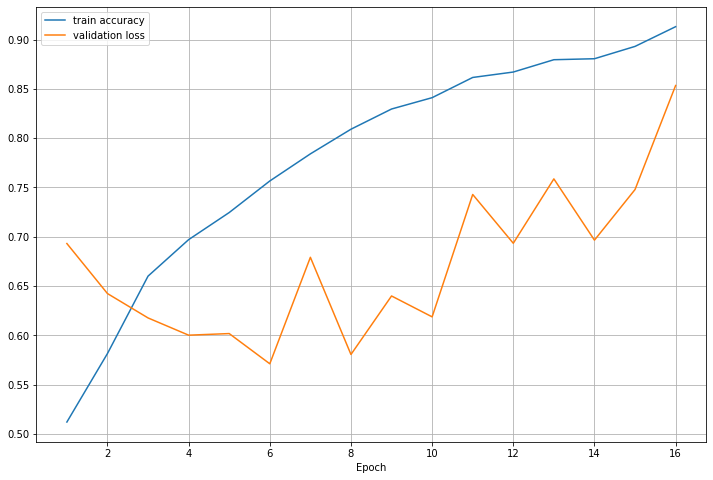

In [24]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.show()